### TRABAJO PRACTICO FINAL

Alumnos: Fernando Vasconcelos, Victoria Teran y Lara Rosenberg

#### OBJETIVO DEL TRABAJO
Partiendo de imagenes de caras de personas, el objetivo será crear un modelo que identifique si son personas jovenes, de edad media o de edad más avanzada

In [2]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 14.4 MB/s eta 0:00:00


In [3]:
# Importamos las librerias necesarias
import kagglehub
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
import shutil
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
def print_results(history):
  fig, axs = plt.subplots(2, 1, figsize=(10, 10))

  axs[0].plot(history["train_loss"])
  axs[0].plot(history["valid_loss"])
  axs[0].title.set_text('Error de Entrenamiento vs Validación')
  axs[0].legend(['Train', 'Valid'])
  axs[0].grid(True)
  axs[1].plot(history["train_acc"])
  axs[1].plot(history["valid_acc"])
  axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
  axs[1].legend(['Train', 'Valid'])
  axs[1].grid(True)

In [4]:
# Descargamos el dataset
path = kagglehub.dataset_download("arashnic/faces-age-detection-dataset")

dataset_path = path + '/faces/train.csv'
image_folder_path = path + '/faces/Train'

100%|██████████| 104M/104M [00:04<00:00, 25.9MB/s]

Extracting files...


In [5]:
# Leemos el csv que tiene el ID de las imagenes y la clase
df = pd.read_csv(dataset_path)

In [6]:
df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


Se ha observado que algunas imágenes en el dataset no corresponden a caras de personas o su calidad es muy deficiente para ser utilizar para entrenar el modelo. A continuación mostramos unos ejemplos.

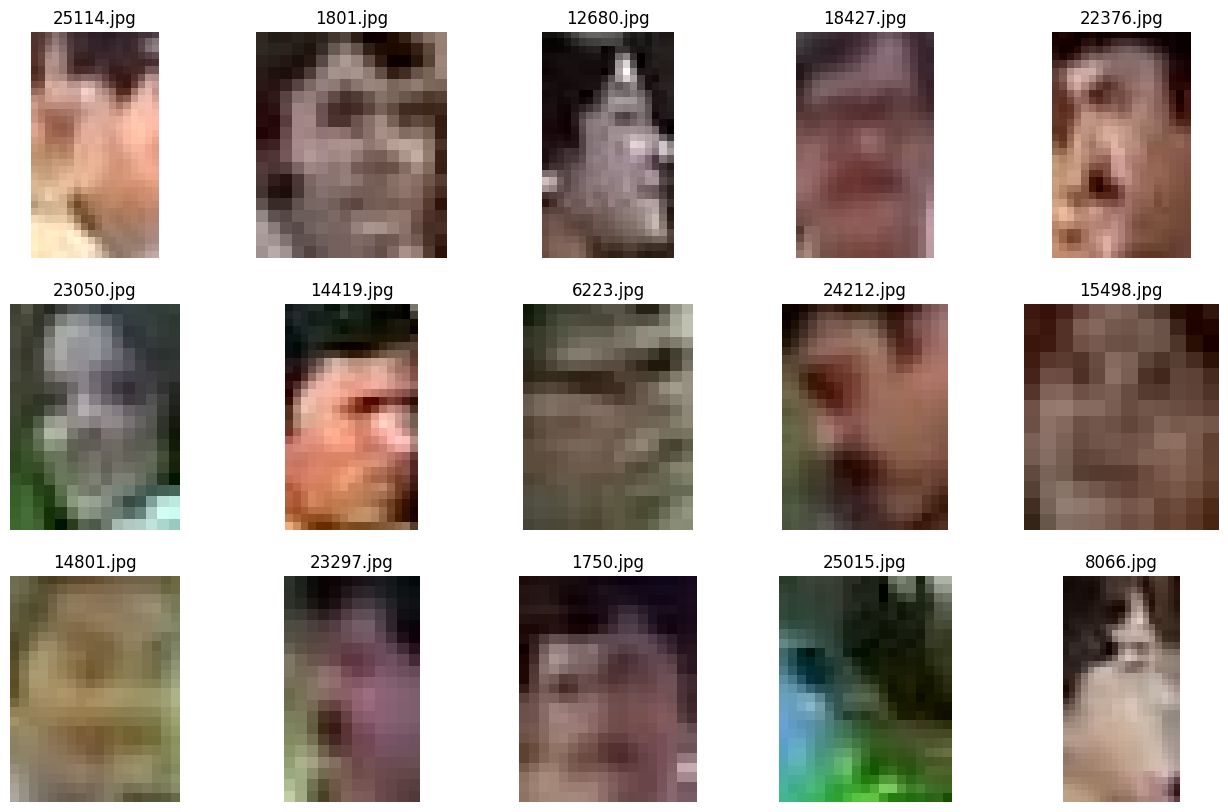

In [7]:
bad_images = ['25114.jpg', '1801.jpg', '12680.jpg', '18427.jpg', '22376.jpg', '23050.jpg', '14419.jpg', '6223.jpg', '24212.jpg', '15498.jpg','14801.jpg', '23297.jpg', '1750.jpg', '25015.jpg', '8066.jpg']

fig, axes = plt.subplots(3, 5, figsize=(16, 10))

# Iteramos sobre las 15 primeras imágenes
for i, image_file in enumerate(bad_images):
    image_path = os.path.join(image_folder_path, image_file)
    etiqueta = df[df['ID'] == image_file].iloc[0]['Class']

    with Image.open(image_path) as img:
        # Determinar la posición en la matriz
        row = i // 5
        col = i % 5
        # Mostramos la imagen en el gráfico
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(f'{image_file}')

A los efectos de eliminar esta imagenes se llevará a cabo un preprocesamiento del dataset con el objetivo de garantizar que todas las imágenes utilizadas contengan rostros válidos. Para ello, se empleará la herramienta MTCNN (Multi-task Cascaded Convolutional Networks) de la biblioteca facenet-pytorch (https://github.com/timesler/facenet-pytorch?tab=readme-ov-file).


*MTCNN es un detector de rostros ampliamente utilizado en aplicaciones de visión por computadora debido a su capacidad para identificar y recortar caras en imágenes de manera precisa y eficiente. Esta herramienta ha sido seleccionada porque ofrece las siguientes ventajas:*

- *Alta precisión en la detección de rostros, incluso en condiciones de iluminación variables o poses no frontales.*
- *Velocidad y escalabilidad, con soporte para procesamiento en GPU, lo cual es esencial para manejar grandes volúmenes de datos.*
- *Facilidad de integración, ya que es compatible con PyTorch y puede aplicarse directamente al dataset sin necesidad de configuraciones adicionales complejas.*

El proceso consistirá en aplicar MTCNN sobre cada imagen del dataset. Si no se detecta ningún rostro, la imagen será eliminada del conjunto de datos. Esto permitirá asegurar que las imágenes restantes sean válidas de modo de no afectar el desempeño del modelo entrenado posteriormente.

Este paso es crucial para optimizar la calidad del dataset y garantizar la validez de los resultados obtenidos en las siguientes etapas del proyecto.

In [ ]:
from facenet_pytorch import MTCNN
mtcnn = MTCNN()
df['face_detected'] = True
for image_file in df['ID']:
    filepath = os.path.join(image_folder_path, image_file)
    try:
        # Detecta las caras
        img = Image.open(filepath)
        boxes, _ = mtcnn.detect(img)
        if boxes is None:  # Si no se detectan caras
            df.loc[df['ID']==image_file, 'face_detected'] = False  # Almacena las imágenes sin caras
    except Exception as e:
        # print(f"Error procesando {image_file}: {e}")
        df.loc[df['ID']==image_file, 'face_detected'] = False


In [ ]:
df.value_counts(df['face_detected'])

face_detected
True     15216
False     4690
Name: count, dtype: int64

Observamos que de las 19906, 4690 no son caras por lo tanto las eliminamos del dataset.

In [ ]:
df = df[df['face_detected'] == True]
df.reset_index(inplace=True)
df = df.drop(columns=['index', 'face_detected'])

In [ ]:
# Guardamos el dataset procesado
# df.to_pickle("./df_cleaned.pkl")

In [8]:
df = pd.read_pickle('./df_cleaned.pkl')

Evaluamos la distribucion de las clases

In [9]:
df.Class.value_counts()

,count
Class,
MIDDLE,7866
YOUNG,5655
OLD,1695


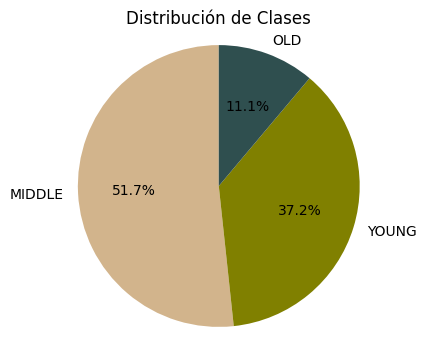

In [10]:
# Creamos el gráfico de torta
plt.figure(figsize=(4, 4))
plt.pie(df.Class.value_counts(), labels=df.Class.value_counts().index, autopct='%1.1f%%', startangle=90, colors=['tan', 'olive','darkslategrey'])
plt.axis('equal')

# Agregamos un título
plt.title('Distribución de Clases')

# Mostramos el gráfico
plt.show()

Como podemos ver, las clases se encuentran desbalanceadas.
Más de la mitad de las imagenes, son clasificadas como "middle".
Solo un 12% de las observaciones, corresponden a edades más avanzadas ("old")

Lo primero que vamos a hacer es revisar si todas las imagenes tienen el mismo tamaño

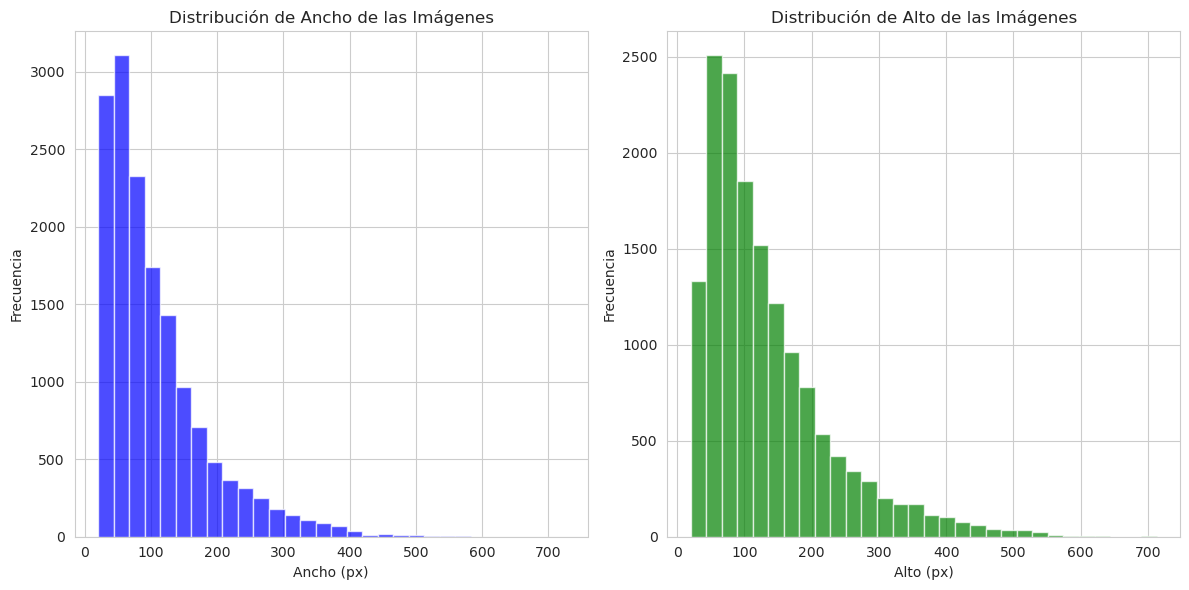

In [ ]:
# Obtenemos todos los archivos de la carpeta
image_files = df['ID']

# Iniciamos listas para almacenar los valores de ancho y alto
widths = []
heights = []
image_sizes = []

# Iteramos sobre los archivos de la carpeta
for image_file in image_files:
    image_path = os.path.join(image_folder_path, image_file)
    with Image.open(image_path) as img:
        width, height = img.size
        image_sizes.append(img.size)
        widths.append(width)
        heights.append(height)

# Creamos los gráficos de distribución para ancho y alto
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histograma del ancho de las imágenes
axes[0].hist(widths, bins=30, color='blue', alpha=0.7)
axes[0].set_title('Distribución de Ancho de las Imágenes')
axes[0].set_xlabel('Ancho (px)')
axes[0].set_ylabel('Frecuencia')

# Histograma del alto de las imágenes
axes[1].hist(heights, bins=30, color='green', alpha=0.7)
axes[1].set_title('Distribución de Alto de las Imágenes')
axes[1].set_xlabel('Alto (px)')
axes[1].set_ylabel('Frecuencia')

# Mostramos los gráficos
plt.tight_layout()
plt.show()

Como podemos ver, las imagenes presentan distintos tamaños, es decir, no son homogeneas.

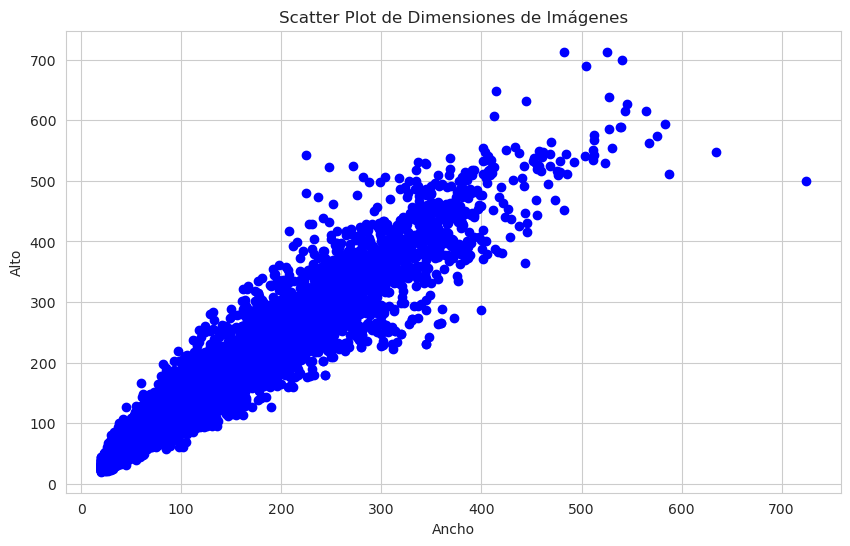

In [ ]:
widths, heights = zip(*image_sizes)

# Creamos el scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, color='blue', marker='o')

# Configuramos el título y las etiquetas
plt.title('Scatter Plot de Dimensiones de Imágenes')
plt.xlabel('Ancho')
plt.ylabel('Alto')
plt.grid(True)

# Mostramos el plot
plt.show()

Como podemos ver, las imágenes no son cuadradas (suelen tener más largo que ancho).

Observamos las primeras 15 imagenes

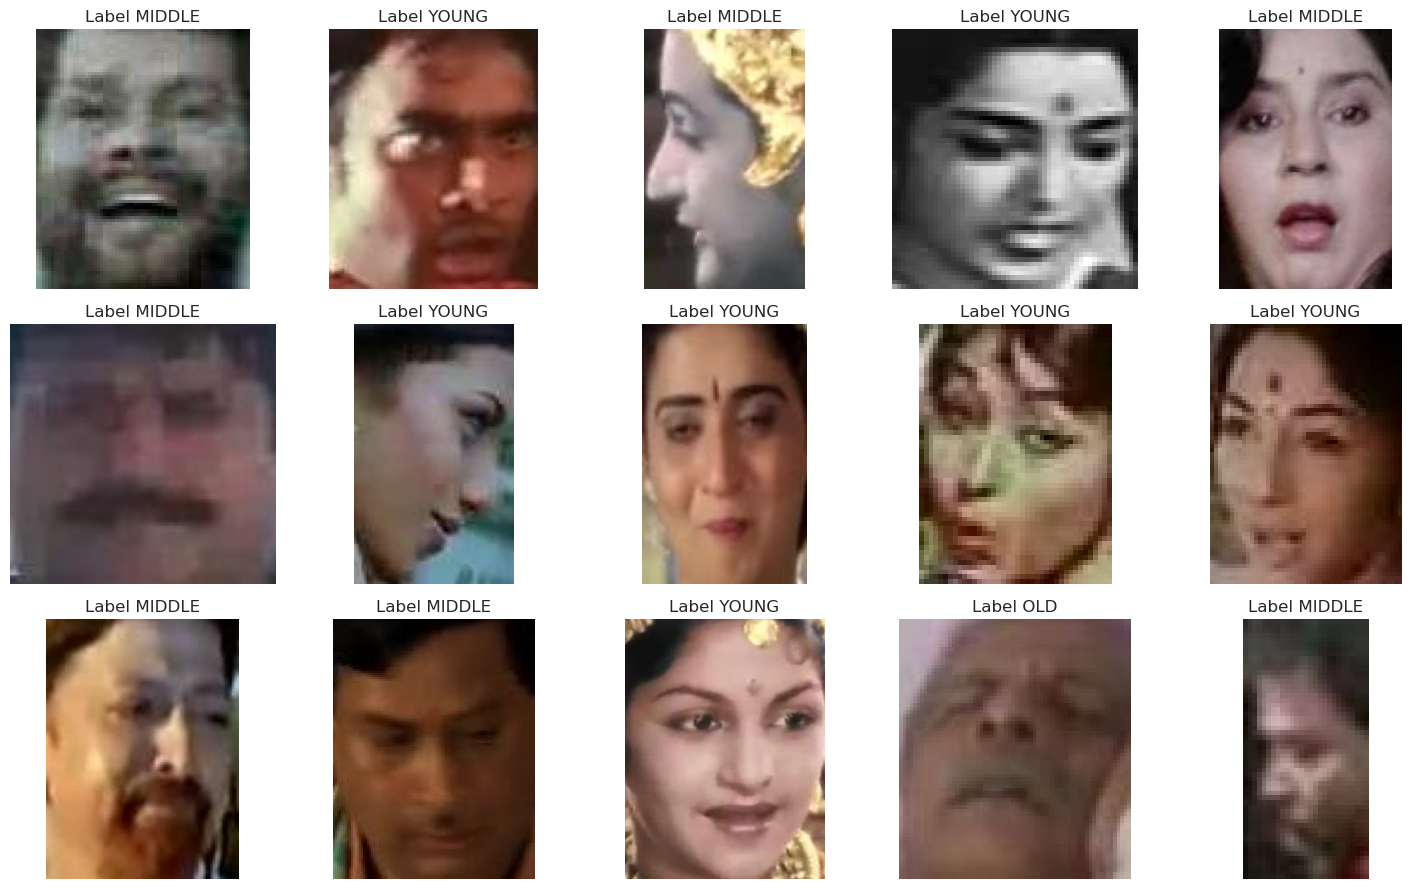

In [ ]:
# Obtenemos las primeras 15 imágenes
first_15_images = df['ID'][:15]

fig, axes = plt.subplots(3, 5, figsize=(15, 9))

# Iteramos sobre las 15 primeras imágenes
for i, image_file in enumerate(first_15_images):
    image_path = os.path.join(image_folder_path, image_file)
    etiqueta = df[df['ID'] == image_file].iloc[0]['Class']

    with Image.open(image_path) as img:
        # Determinar la posición en la matriz
        row = i // 5
        col = i % 5

        # Mostramos la imagen en el gráfico
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Label {etiqueta}')

# Ajustamos el espacio entre las subgráficas
plt.tight_layout()

# Mostramos el gráfico
plt.show()

In [11]:
# Data Preprocessing --> cambiamos los labels de str a int
class_mapping = {'YOUNG': 0, 'MIDDLE': 1, 'OLD': 2}
df['Class'] = df['Class'].map(class_mapping)

In [12]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Class'])

print(f'Tamaño conjunto de entrenamiento: {len(train_df)}')
print(f'Tamaño conjunto de test: {len(test_df)}')

Tamaño conjunto de entrenamiento: 12172
Tamaño conjunto de test: 3044


In [13]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, images_dir, transform=None):
        self.dataframe = dataframe
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]  # Nombre de la imagen (ID)
        label = self.dataframe.iloc[idx, 1]     # Clase correspondiente
        img_path = os.path.join(self.images_dir, img_name)

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

Tamaño original de la imagen: 309x387


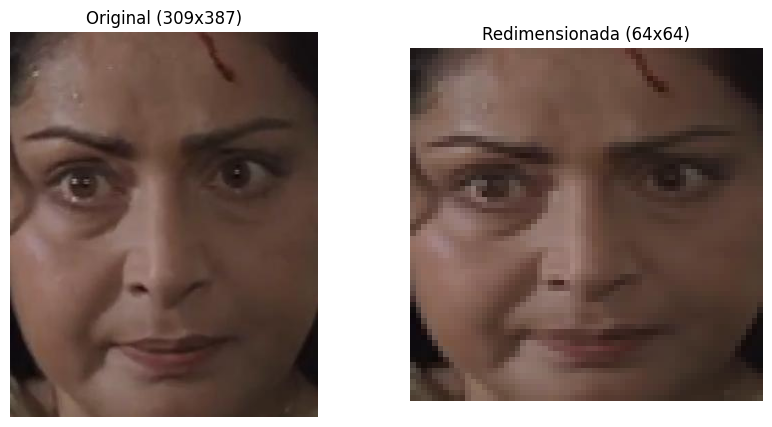

In [14]:
# Cargamos la imagen original
img_path = image_folder_path + '/1.jpg'
original_image = Image.open(img_path)

# Mostramos las dimensiones de la imagen original
original_size = original_image.size
print(f"Tamaño original de la imagen: {original_size[0]}x{original_size[1]}")

# Definimos el tamaño del resize
resize_transform = transforms.Resize((64, 64), interpolation=Image.LANCZOS)

# Aplicamos la transformación sobre la imagen
resized_image = resize_transform(original_image)

# Mostramos las imágenes: original y redimensionada
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(original_image)
axes[0].set_title(f"Original ({original_size[0]}x{original_size[1]})")
axes[0].axis("off")

resized_size = resized_image.size
axes[1].imshow(resized_image)
axes[1].set_title(f"Redimensionada ({resized_size[0]}x{resized_size[1]})")
axes[1].axis("off")

plt.show()

1. ARQUITECTURA BASICA

In [15]:
CANTIDAD_CLASES = 3
ANCHO_IMAGENES = 64
ALTO_IMAGENES = 64

In [16]:
transform = transforms.Compose([
    transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
    transforms.ToTensor(),
])

In [17]:
# Creamos los datasets
train_dataset = CustomDataset(dataframe=train_df, images_dir=image_folder_path, transform=transform)
test_dataset = CustomDataset(dataframe=test_df, images_dir=image_folder_path, transform=transform)

# Creamos los dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [26]:
class ConvModel(torch.nn.Module):
    def __init__(self, output_units):
        super().__init__()
        self.dropout2d = torch.nn.Dropout2d(0.3)
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.bn3 = torch.nn.BatchNorm2d(64)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.bn4 = torch.nn.BatchNorm2d(128)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=2048, out_features=512)
        self.dropout = torch.nn.Dropout(p=0.3)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(self.dropout2d(x)))))
        x = self.pool4(torch.relu(self.bn4(self.conv4(self.dropout2d(x)))))
        # x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        # x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(self.dropout(x)))
        # x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModel(CANTIDAD_CLASES)

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (3, ANCHO_IMAGENES, ALTO_IMAGENES))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
       BatchNorm2d-2           [-1, 16, 64, 64]              32
         MaxPool2d-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         MaxPool2d-6           [-1, 32, 16, 16]               0
         Dropout2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        MaxPool2d-10             [-1, 64, 8, 8]               0
        Dropout2d-11             [-1, 64, 8, 8]               0
           Conv2d-12            [-1, 128, 8, 8]          73,856
      BatchNorm2d-13            [-1, 128, 8, 8]             256
        MaxPool2d-14            [-1, 12

In [22]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]



    if tb_writer:
      train_writer = tb_writer["train"]
      valid_writer = tb_writer["valid"]
      train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
      valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    # if torch.cuda.is_available():
    #     model.to("cuda")
    #     metric.to("cuda")


    model.to(device)
    metric.to(device)

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            # if torch.cuda.is_available():
            #     train_data = train_data.to("cuda")
            #     train_target = train_target.to("cuda")

            train_data = train_data.to(device)
            train_target = train_target.to(device)

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

In [20]:
# Dado que las clases se encuentran desbalanceadas vamos a utilizar el argumento weight de CrossEntropy
class_counts = np.bincount(train_dataset.dataframe.Class)
class_weights = 1. / class_counts  # Invertir la frecuencia para dar más peso a las clases menos frecuentes
class_weights = class_weights / class_weights.sum()
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [28]:
noaug_conv_model = ConvModel(CANTIDAD_CLASES)
noaug_optimizer = torch.optim.Adam(noaug_conv_model.parameters(), lr=0.001, weight_decay=0.001)
noaug_loss = torch.nn.CrossEntropyLoss(weight=weights)
noaug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro')
noaug_data = {"train": train_loader, "valid": test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

noaug_writer = {"train": SummaryWriter(log_dir="data_aug/noaug_train"),
                "valid": SummaryWriter(log_dir="data_aug/noaug_valid")}

history = train(noaug_conv_model,
                noaug_optimizer,
                noaug_loss,
                noaug_metric,
                noaug_data,
                20,
                None)

Epoch: 1/20 - Train loss 1.044278 - Train Accuracy 0.484009 - Valid Loss 0.910457 - Valid Accuracy 0.586805
Epoch: 2/20 - Train loss 0.854947 - Train Accuracy 0.610316 - Valid Loss 0.828917 - Valid Accuracy 0.610359
Epoch: 3/20 - Train loss 0.794804 - Train Accuracy 0.653989 - Valid Loss 0.816534 - Valid Accuracy 0.653294
Epoch: 4/20 - Train loss 0.755774 - Train Accuracy 0.676439 - Valid Loss 0.711318 - Valid Accuracy 0.699339
Epoch: 5/20 - Train loss 0.731565 - Train Accuracy 0.680406 - Valid Loss 0.708256 - Valid Accuracy 0.694696
Epoch: 6/20 - Train loss 0.699634 - Train Accuracy 0.702753 - Valid Loss 0.688330 - Valid Accuracy 0.702912
Epoch: 7/20 - Train loss 0.672354 - Train Accuracy 0.712870 - Valid Loss 0.660789 - Valid Accuracy 0.722800
Epoch: 8/20 - Train loss 0.664672 - Train Accuracy 0.717894 - Valid Loss 0.662207 - Valid Accuracy 0.730635
Epoch: 9/20 - Train loss 0.644729 - Train Accuracy 0.734205 - Valid Loss 0.661240 - Valid Accuracy 0.720389
Epoch: 10/20 - Train loss 0.

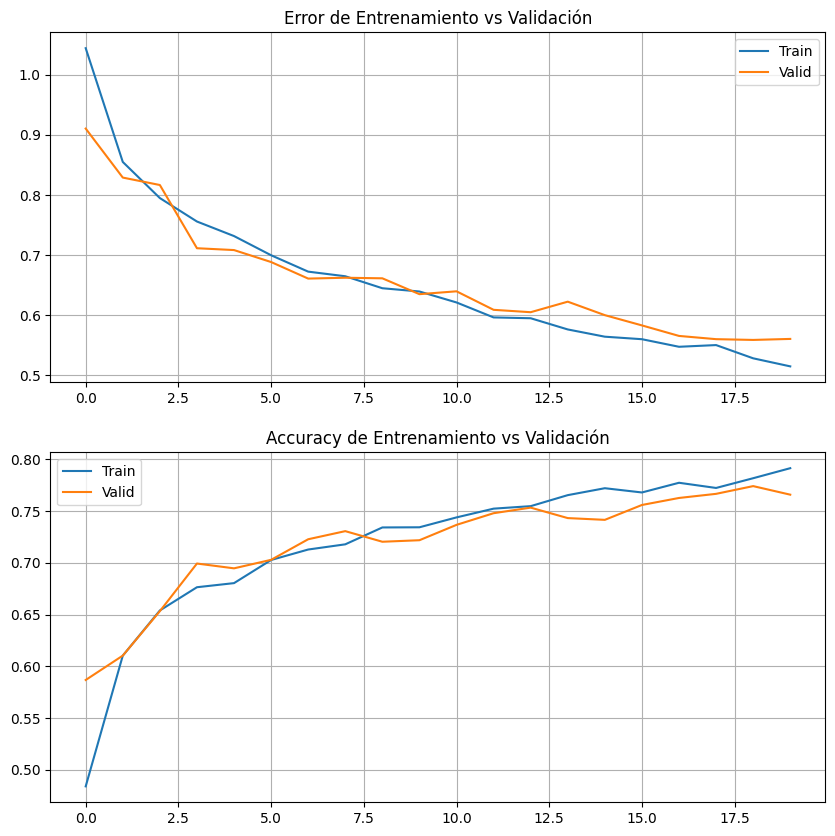

In [33]:
print_results(history)

2. DATA AUGMENTATION

Como estamos trabajando con imágenes de caras de personas, es importante asegurarnos de que las transformaciones no distorsionen los rasgos faciales. Por ejemplo, hacer una rotación demasiado grande o un escalado excesivo podría alterar la posición de los ojos, la nariz o la boca, lo cual podría hacer que el modelo no aprenda correctamente.

Transformaciones propuestas:

- transforms.RandomHorizontalFlip:

Refleja las caras horizontalmente sin perder ningún detalle relevante. Esto puede ayudar al modelo a aprender a reconocer las caras sin importar la dirección en la que están orientadas.
Uso: transforms.RandomHorizontalFlip(p=0.5) (50% de probabilidad de hacer el flip).

- transforms.RandomRotation:

Las rotaciones moderadas pensamos que pueden ser útiles en este caso.
Uso: transforms.RandomRotation(degrees=15) (esto permite rotaciones aleatorias de hasta 15 grados en ambas direcciones).

- transforms.ColorJitter:

Esta transformación ajusta aleatoriamente el brillo, contraste, saturación y tonalidad de la imagen. Ayuda a hacer que el modelo sea robusto frente a variaciones de iluminación y color en las caras.
Uso: transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1).


- transforms.RandomAffine:

Permite aplicar transformaciones de traslación, rotación, escalado y/o sesgo en las imágenes.
Uso: transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)). Esto permite pequeñas rotaciones (10°), desplazamientos (10% de la imagen) y escalados moderados.

- transforms.RandomPerspective:

Realiza transformaciones de perspectiva que pueden hacer que la imagen se vea como si fuera tomada desde otro ángulo. Es útil para robustecer al modelo frente a cambios de perspectiva de la imagen.
Uso: transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3).

In [45]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomRotation(degrees=25),
                        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                        #torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                        #torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
                        torchvision.transforms.ToTensor(),
                      ])


In [46]:
transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                    torchvision.transforms.ToTensor()
                  ])

# Creamos los Datasets
aug_train_set = CustomDataset(dataframe=train_df, images_dir=image_folder_path, transform=aug_data_transforms)
aug_test_set = CustomDataset(dataframe=test_df, images_dir=image_folder_path, transform=transforms)

# Creamos los DataLoaders
aug_train_loader = DataLoader(aug_train_set, batch_size=64, shuffle=True)
aug_test_loader = DataLoader(aug_test_set, batch_size=64, shuffle=False)


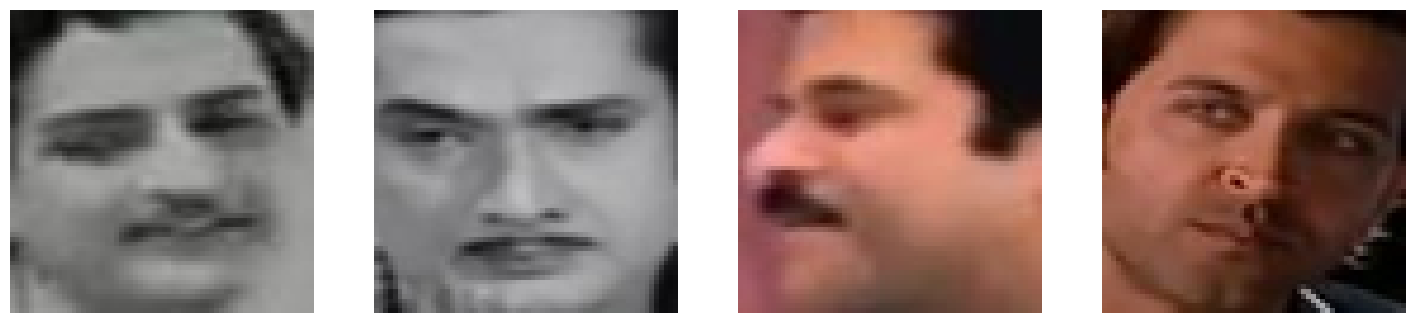

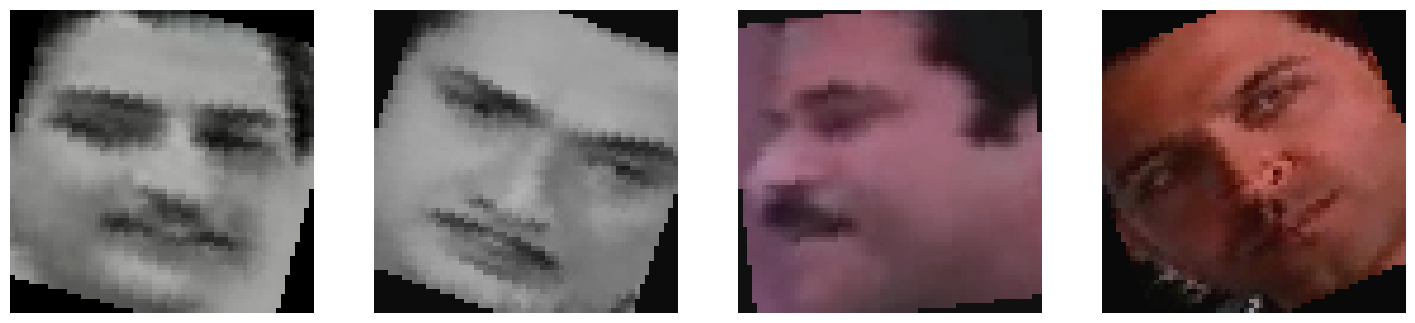

In [36]:
images_ids = np.random.randint(low=0, high=len(train_dataset), size=4)

# Ploteo las imagenes sin augmentacion

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(train_dataset[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

# Ploteo las mismas imagenes con augmentacion

fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

for id, row in enumerate(rows):
    row.imshow(aug_train_set[images_ids[id]][0].permute(1, 2, 0))
    row.axis('off')
plt.show()

Epoch: 1/20 - Train loss 1.062579 - Train Accuracy 0.446639 - Valid Loss 0.952113 - Valid Accuracy 0.524217
Epoch: 2/20 - Train loss 0.942656 - Train Accuracy 0.540981 - Valid Loss 0.904456 - Valid Accuracy 0.568629
Epoch: 3/20 - Train loss 0.883357 - Train Accuracy 0.594876 - Valid Loss 0.874596 - Valid Accuracy 0.592535
Epoch: 4/20 - Train loss 0.841029 - Train Accuracy 0.621573 - Valid Loss 0.786019 - Valid Accuracy 0.650813
Epoch: 5/20 - Train loss 0.824961 - Train Accuracy 0.629181 - Valid Loss 0.761438 - Valid Accuracy 0.674981
Epoch: 6/20 - Train loss 0.809187 - Train Accuracy 0.649697 - Valid Loss 0.737033 - Valid Accuracy 0.683579
Epoch: 7/20 - Train loss 0.799153 - Train Accuracy 0.645928 - Valid Loss 0.727947 - Valid Accuracy 0.688180
Epoch: 8/20 - Train loss 0.785730 - Train Accuracy 0.663673 - Valid Loss 0.729073 - Valid Accuracy 0.695174
Epoch: 9/20 - Train loss 0.767600 - Train Accuracy 0.670757 - Valid Loss 0.715368 - Valid Accuracy 0.691118
Epoch: 10/20 - Train loss 0.

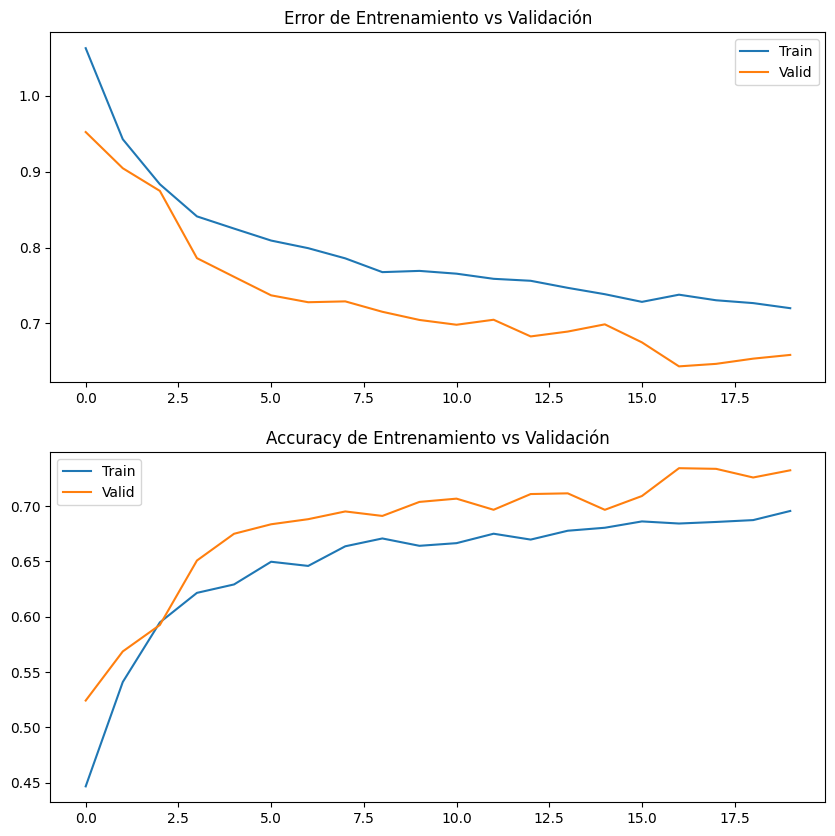

In [37]:
aug_conv_model = ConvModel(CANTIDAD_CLASES)
aug_optimizer = torch.optim.Adam(aug_conv_model.parameters(),lr=0.001, weight_decay=0.001)
aug_loss = torch.nn.CrossEntropyLoss(weight=weights)
aug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro')
aug_data = {"train": aug_train_loader, "valid": aug_test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

aug_writer = {"train": SummaryWriter(log_dir="data_aug/aug_train"),
              "valid": SummaryWriter(log_dir="data_aug/aug_valid")}

history = train(aug_conv_model,
                aug_optimizer,
                aug_loss,
                aug_metric,
                aug_data,
                20,
                None)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

# arquitectura basica
# Epoch: 15/15 - Train loss 0.584816 - Train Accuracy 0.653090 - Valid Loss 0.632798 - Valid Accuracy 0.603356


Con el uso de data augmentation, observamos que el modelo queda subajustado tras 20 épocas de entrenamiento. Por lo tanto, para lograr un entrenamiento adecuado, sería necesario aumentar el número de épocas.
En el próximo modelo, decidimos eliminar el dropout y el weight decay, dejando únicamente el data augmentation como técnica de regularización.

In [44]:
class ConvModelWithoutDropout(torch.nn.Module):
    def __init__(self, output_units):
        super().__init__()
        self.dropout2d = torch.nn.Dropout2d(0.3)
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.bn3 = torch.nn.BatchNorm2d(64)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.bn4 = torch.nn.BatchNorm2d(128)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=2048, out_features=512)
        self.dropout = torch.nn.Dropout(p=0.3)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        # x = self.pool3(torch.relu(self.bn3(self.conv3(self.dropout2d(x)))))
        # x = self.pool4(torch.relu(self.bn4(self.conv4(self.dropout2d(x)))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        x = torch.flatten(x, 1)
        # x = torch.relu(self.fc1(self.dropout(x)))
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModelWithoutDropout(CANTIDAD_CLASES)

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (3, ANCHO_IMAGENES, ALTO_IMAGENES))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
       BatchNorm2d-2           [-1, 16, 64, 64]              32
         MaxPool2d-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
         MaxPool2d-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          18,496
       BatchNorm2d-8           [-1, 64, 16, 16]             128
         MaxPool2d-9             [-1, 64, 8, 8]               0
           Conv2d-10            [-1, 128, 8, 8]          73,856
      BatchNorm2d-11            [-1, 128, 8, 8]             256
        MaxPool2d-12            [-1, 128, 4, 4]               0
           Linear-13                  [-1, 512]       1,049,088
           Linear-14                   

Epoch: 1/20 - Train loss 1.063286 - Train Accuracy 0.465029 - Valid Loss 0.976009 - Valid Accuracy 0.527249
Epoch: 2/20 - Train loss 0.860596 - Train Accuracy 0.610382 - Valid Loss 0.864473 - Valid Accuracy 0.604633
Epoch: 3/20 - Train loss 0.786519 - Train Accuracy 0.652459 - Valid Loss 0.772707 - Valid Accuracy 0.651057
Epoch: 4/20 - Train loss 0.754055 - Train Accuracy 0.667321 - Valid Loss 0.749035 - Valid Accuracy 0.669238
Epoch: 5/20 - Train loss 0.728614 - Train Accuracy 0.691441 - Valid Loss 0.678897 - Valid Accuracy 0.714737
Epoch: 6/20 - Train loss 0.706391 - Train Accuracy 0.696058 - Valid Loss 0.723893 - Valid Accuracy 0.678048
Epoch: 7/20 - Train loss 0.689759 - Train Accuracy 0.703656 - Valid Loss 0.766015 - Valid Accuracy 0.679749
Epoch: 8/20 - Train loss 0.678703 - Train Accuracy 0.715737 - Valid Loss 0.633608 - Valid Accuracy 0.739842
Epoch: 9/20 - Train loss 0.658979 - Train Accuracy 0.720018 - Valid Loss 0.659135 - Valid Accuracy 0.729081
Epoch: 10/20 - Train loss 0.

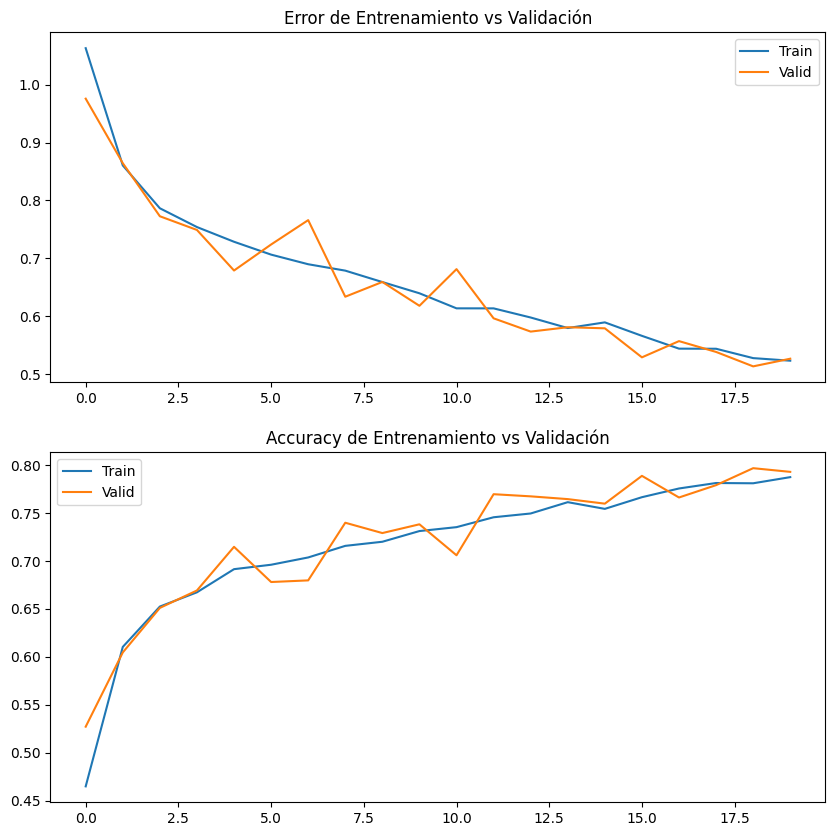

In [51]:
aug_conv_model_2 = ConvModelWithoutDropout(CANTIDAD_CLASES)
aug_optimizer = torch.optim.Adam(aug_conv_model_2.parameters(),lr=0.001)#, weight_decay=0.001)
aug_loss = torch.nn.CrossEntropyLoss(weight=weights)
aug_metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro')
aug_data = {"train": aug_train_loader, "valid": aug_test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}

aug_writer = {"train": SummaryWriter(log_dir="data_aug/aug_train"),
              "valid": SummaryWriter(log_dir="data_aug/aug_valid")}

history = train(aug_conv_model_2,
                aug_optimizer,
                aug_loss,
                aug_metric,
                aug_data,
                20,
                None)

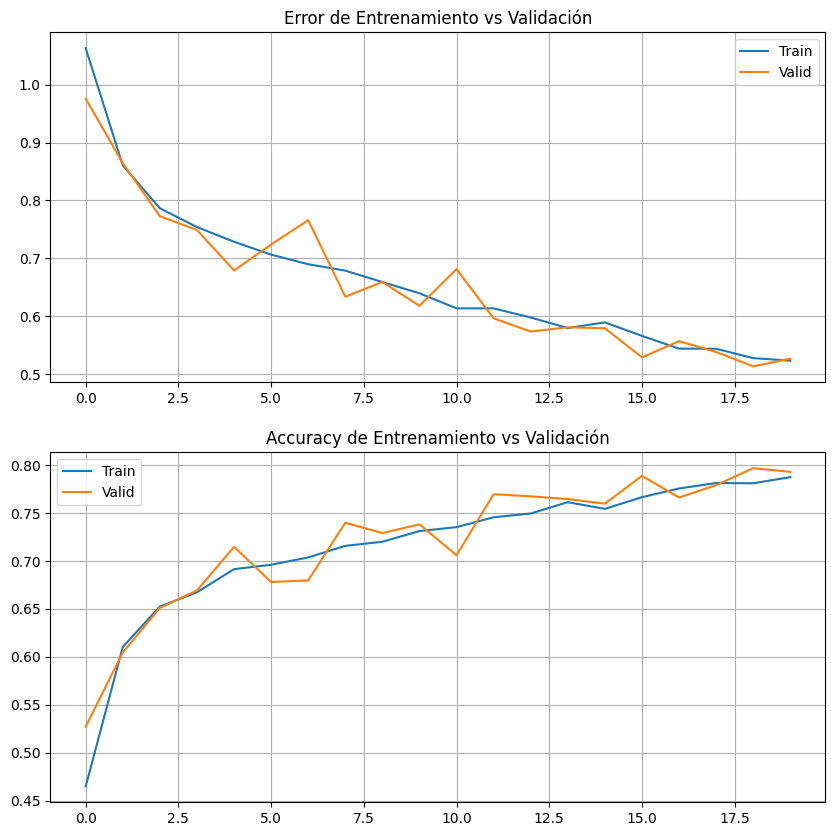

In [52]:
print_results(history)

El proceso de data augmentation genera resultados similares a los obtenidos al entrenar el modelo con dropout y weight decay. Sin embargo, observamos que tanto el conjunto de entrenamiento como el de validación convergen adecuadamente. Por lo tanto, sería posible incrementar el número de épocas para explorar un mejor ajuste del modelo.

3. TRANSFER LEARNING: VGG19


In [ ]:
CANTIDAD_CLASES = 3
ANCHO_IMAGENES = 64
ALTO_IMAGENES = 64

In [ ]:
from torchvision.models.vgg import VGG19_Weights

weights = VGG19_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [ ]:
vgg19_model = torchvision.models.vgg19(weights=weights)

#vgg19_model.to("cuda")
#torchsummary.summary(vgg19_model, input_size=(3, 224, 224))
#vgg19_model.modules

In [ ]:
aug_data_transforms = torchvision.transforms.Compose([
                        #torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomRotation(degrees=25),
                        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                        #torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                        #torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
                        torchvision.transforms.ToTensor(),
                      ])

transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                    torchvision.transforms.ToTensor()
                  ])


# Creamos los Datasets
aug_train_set = CustomDataset(dataframe=train_df, images_dir=image_folder_path, transform=transforms)
aug_test_set = CustomDataset(dataframe=test_df, images_dir=image_folder_path, transform=transforms)

# Creamos los DataLoaders
aug_train_loader = DataLoader(aug_train_set, batch_size=64, shuffle=True)
aug_test_loader = DataLoader(aug_test_set, batch_size=64, shuffle=False)


In [ ]:
for param in vgg19_model.parameters():
    param.requires_grad = False

In [ ]:
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)
torchsummary.summary(vgg19_model, input_size=(3, ANCHO_IMAGENES, ALTO_IMAGENES))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]          73,856
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,584
              ReLU-9          [-1, 128, 32, 32]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         295,168
             ReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
             ReLU-14          [-1, 256,

In [ ]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):

    train_loader = data["train"]
    valid_loader = data["valid"]




    if tb_writer:
        train_writer = tb_writer["train"]
        valid_writer = tb_writer["valid"]
        train_writer.add_graph(model, torch.zeros((1, 3), data["image_width"], data["image_height"]))
        valid_writer.add_graph(model, torch.zeros((1, 3), data["image_width"], data["image_height"]))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

In [ ]:
optimizer = torch.optim.Adam(vgg19_model.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro' )
data = {"train": aug_train_loader, "valid": aug_test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
writer = {"train": SummaryWriter(log_dir="transfer_learning_vgg/train"),
          "valid": SummaryWriter(log_dir="transfer_learning_vgg/valid")}


history = train(vgg19_model,#.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                15,
                None)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Test')
axs[0].legend(['Train', 'Test'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Test')
axs[1].legend(['Train', 'Test'])

# arquitectura basica
# Epoch: 15/15 - Train loss 0.584816 - Train Accuracy 0.653090 - Valid Loss 0.632798 - Valid Accuracy 0.603356
# data augmentation
# Epoch: 15/15 - Train loss 0.530651 - Train Accuracy 0.700656 - Valid Loss 0.544694 - Valid Accuracy 0.701688

TypeError: cannot assign 'torchvision.models.vgg.VGG19_Weights' object to buffer 'weight' (torch Tensor or None required)

4. TRANSFER LEARNING: RESNET18

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [ ]:
resnet18_model = resnet18(weights=weights)

if torch.cuda.is_available():
    resnet18_model.to("cuda")

torchsummary.summary(resnet18_model, input_size=(3, 32, 32))
resnet18_model.modules

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:06<00:00, 7.76MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer3): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(

In [ ]:
for param in resnet18_model.parameters():
    param.requires_grad = False

last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

NameError: name 'CANTIDAD_CLASES' is not defined

In [ ]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomRotation(degrees=25),
                        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                        #torchvision.transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                        #torchvision.transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
                        torchvision.transforms.ToTensor(),
                      ])

transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES), interpolation=Image.LANCZOS),
                    torchvision.transforms.ToTensor()
                  ])



images_dir = '/content/faces-age-detection-dataset/faces/Train'  # Cambia esto a la ruta de tu carpeta de imágenes

# Crear Datasets
aug_train_set = CustomDataset(dataframe=train_df, images_dir=images_dir, transform=aug_data_transforms)
aug_test_set = CustomDataset(dataframe=test_df, images_dir=images_dir, transform=transforms)

# Crear DataLoaders
aug_train_loader = DataLoader(aug_train_set, batch_size=64, shuffle=True)
aug_test_loader = DataLoader(aug_test_set, batch_size=64, shuffle=False)

Epoch: 1/15 - Train loss 0.985177 - Train Accuracy 0.374684 - Valid Loss 0.968115 - Valid Accuracy 0.385228
Epoch: 2/15 - Train loss 0.895310 - Train Accuracy 0.419243 - Valid Loss 0.934302 - Valid Accuracy 0.418434
Epoch: 3/15 - Train loss 0.866865 - Train Accuracy 0.437861 - Valid Loss 0.923185 - Valid Accuracy 0.431637
Epoch: 4/15 - Train loss 0.847533 - Train Accuracy 0.449203 - Valid Loss 0.918754 - Valid Accuracy 0.446518
Epoch: 5/15 - Train loss 0.835963 - Train Accuracy 0.457448 - Valid Loss 0.897940 - Valid Accuracy 0.445474
Epoch: 6/15 - Train loss 0.820139 - Train Accuracy 0.467866 - Valid Loss 0.892738 - Valid Accuracy 0.451844
Epoch: 7/15 - Train loss 0.813855 - Train Accuracy 0.469385 - Valid Loss 0.900516 - Valid Accuracy 0.451099
Epoch: 8/15 - Train loss 0.805010 - Train Accuracy 0.481770 - Valid Loss 0.887045 - Valid Accuracy 0.451594
Epoch: 9/15 - Train loss 0.802300 - Train Accuracy 0.482244 - Valid Loss 0.878832 - Valid Accuracy 0.461448
Epoch: 10/15 - Train loss 0.

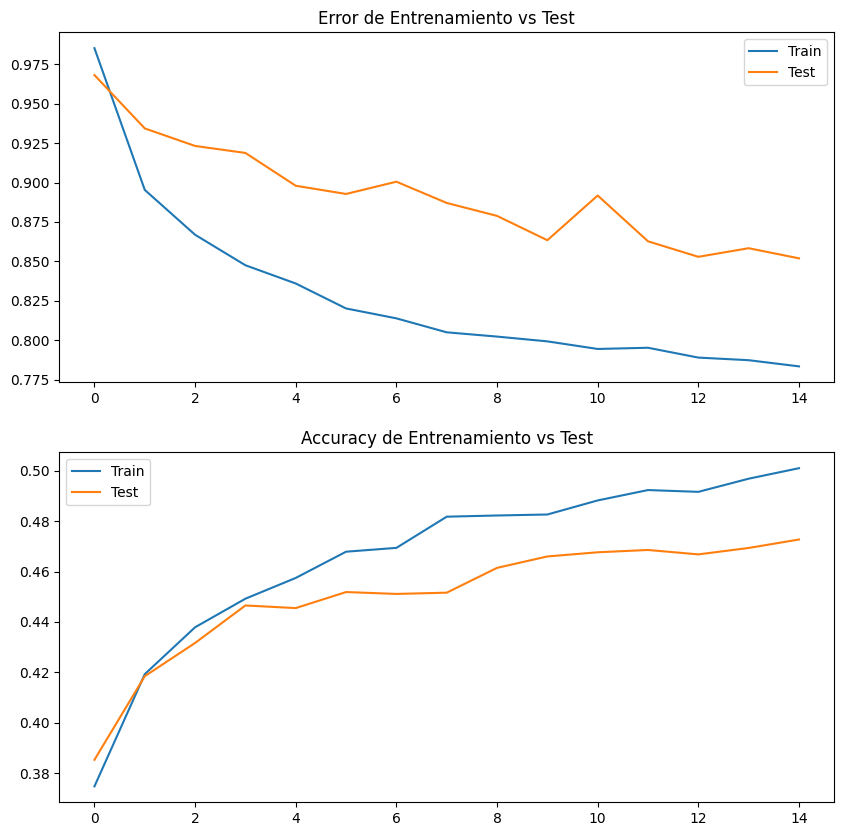

In [ ]:
optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro' )
data = {"train": aug_train_loader, "valid": aug_test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
writer = {"train": SummaryWriter(log_dir="transfer_learning_resnet18/train"),
          "valid": SummaryWriter(log_dir="transfer_learning_resnet18/valid")}


history = train(resnet18_model.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                15,
                writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Test')
axs[0].legend(['Train', 'Test'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Test')
axs[1].legend(['Train', 'Test'])

# arquitectura basica
# Epoch: 15/15 - Train loss 0.584816 - Train Accuracy 0.653090 - Valid Loss 0.632798 - Valid Accuracy 0.603356
# data augmentation
# Epoch: 15/15 - Train loss 0.530651 - Train Accuracy 0.700656 - Valid Loss 0.544694 - Valid Accuracy 0.701688
# TL vgg19
# Epoch: 15/15 - Train loss 0.817499 - Train Accuracy 0.479971 - Valid Loss 0.834366 - Valid Accuracy 0.478292

5. TL RESNET18 DESDE LAYER4

In [53]:
CANTIDAD_CLASES = 3
ANCHO_IMAGENES = 150
ALTO_IMAGENES = 150

In [59]:
weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [61]:
resnet18_model = resnet18(weights=weights)

resnet18_model.to(device)

print(resnet18_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [58]:
# Congelar todas las capas inicialmente
for param in resnet18_model.parameters():
    param.requires_grad = False

# Descongelar las capas del último bloque (layer4)
for layer in resnet18_model.layer4:
    for param in layer.parameters():
        param.requires_grad = True  # Habilitar el entrenamiento para las capas de layer4

# Descongelar la capa final (fc)
last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

# Definir un bloque básico modificado que incluye Dropout
class BasicBlockWithDropout(torch.nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.5):
        super(BasicBlockWithDropout, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.dropout = torch.nn.Dropout(p=dropout_prob)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.downsample = downsample  # Guardar la capa de downsample si se necesita

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # Aplicar Dropout después de la ReLU

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Reemplazar layer4 en el modelo con bloques que contienen Dropout
class ModifiedResNet18(torch.nn.Module):
    def __init__(self, original_model):
        super(ModifiedResNet18, self).__init__()
        self.resnet = original_model

        # Reemplazar layer4 con bloques que contienen Dropout
        self.resnet.layer4 = self._replace_with_dropout(self.resnet.layer4)

    def _replace_with_dropout(self, layer4):
        new_layer4 = []
        for block in layer4:
            in_channels = block.conv1.in_channels
            out_channels = block.conv2.out_channels
            stride = block.stride
            downsample = block.downsample

            # Crear el nuevo bloque con Dropout
            new_block = BasicBlockWithDropout(in_channels, out_channels, stride=stride, downsample=downsample, dropout_prob=0.5)
            new_layer4.append(new_block)

        return torch.nn.Sequential(*new_layer4)

    def forward(self, x):
        return self.resnet(x)

# Creamos el modelo modificado
resnet18_model_mod = ModifiedResNet18(resnet18_model)


check_requires_grad(resnet18_model_mod)

AttributeError: 'BasicBlockWithDropout' object has no attribute 'stride'

In [62]:
print(resnet18_model_mod)

ModifiedResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
%%time
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet18_model_mod.parameters()),lr=0.0001)
loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro' )
data = {"train": aug_train_loader, "valid": aug_valid_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
#writer = {"train": SummaryWriter(log_dir="transfer_learning_vgg/train"),
#          "valid": SummaryWriter(log_dir="transfer_learning_vgg/valid")}


history = train(resnet18_model_mod.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                2)
                #writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

conv1.weight: requires_grad = False
bn1.weight: requires_grad = False
bn1.bias: requires_grad = False
layer1.0.conv1.weight: requires_grad = False
layer1.0.bn1.weight: requires_grad = False
layer1.0.bn1.bias: requires_grad = False
layer1.0.conv2.weight: requires_grad = False
layer1.0.bn2.weight: requires_grad = False
layer1.0.bn2.bias: requires_grad = False
layer1.1.conv1.weight: requires_grad = False
layer1.1.bn1.weight: requires_grad = False
layer1.1.bn1.bias: requires_grad = False
layer1.1.conv2.weight: requires_grad = False
layer1.1.bn2.weight: requires_grad = False
layer1.1.bn2.bias: requires_grad = False
layer2.0.conv1.weight: requires_grad = False
layer2.0.bn1.weight: requires_grad = False
layer2.0.bn1.bias: requires_grad = False
layer2.0.conv2.weight: requires_grad = False
layer2.0.bn2.weight: requires_grad = False
layer2.0.bn2.bias: requires_grad = False
layer2.0.downsample.0.weight: requires_grad = False
layer2.0.downsample.1.weight: requires_grad = False
layer2.0.downsample.

Epoch: 1/15 - Train loss 0.715007 - Train Accuracy 0.572244 - Valid Loss 0.658022 - Valid Accuracy 0.629074
Epoch: 2/15 - Train loss 0.574380 - Train Accuracy 0.673287 - Valid Loss 0.609721 - Valid Accuracy 0.662581
Epoch: 3/15 - Train loss 0.512554 - Train Accuracy 0.726234 - Valid Loss 0.560053 - Valid Accuracy 0.691981
Epoch: 4/15 - Train loss 0.460065 - Train Accuracy 0.759085 - Valid Loss 0.541177 - Valid Accuracy 0.738905
Epoch: 5/15 - Train loss 0.417716 - Train Accuracy 0.783661 - Valid Loss 0.525868 - Valid Accuracy 0.715566
Epoch: 6/15 - Train loss 0.387226 - Train Accuracy 0.807240 - Valid Loss 0.496810 - Valid Accuracy 0.776661
Epoch: 7/15 - Train loss 0.354395 - Train Accuracy 0.830953 - Valid Loss 0.498243 - Valid Accuracy 0.760762
Epoch: 8/15 - Train loss 0.323002 - Train Accuracy 0.842174 - Valid Loss 0.474271 - Valid Accuracy 0.752820
Epoch: 9/15 - Train loss 0.307550 - Train Accuracy 0.851312 - Valid Loss 0.462304 - Valid Accuracy 0.804507
Epoch: 10/15 - Train loss 0.

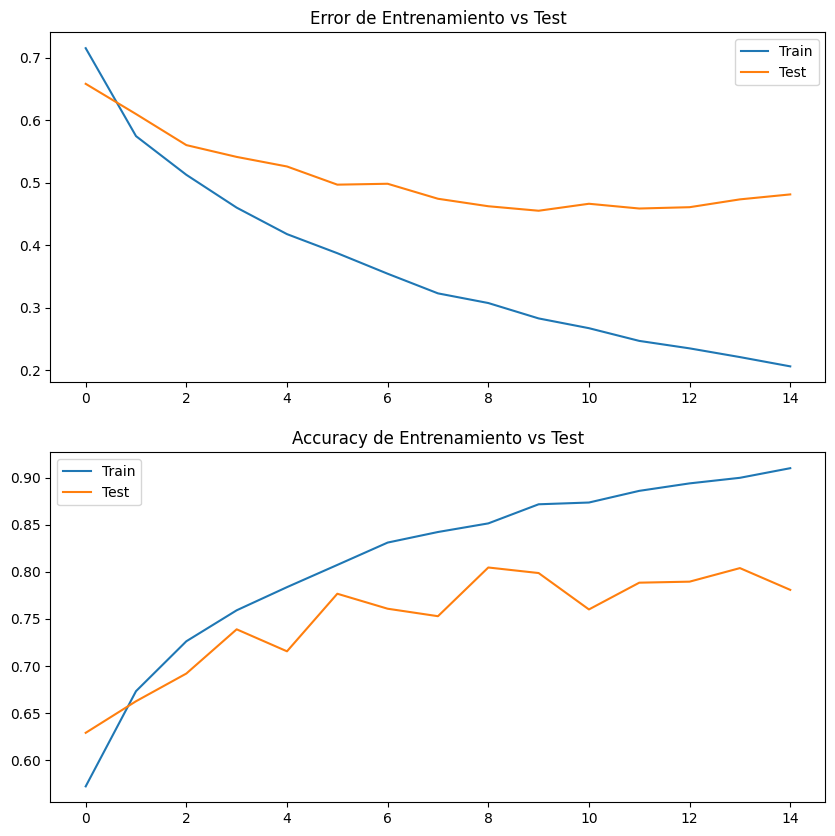

In [ ]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, resnet18_model.parameters()),
    lr=0.0001)

#optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro' )
data = {"train": aug_train_loader, "valid": aug_test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
writer = {"train": SummaryWriter(log_dir="transfer_learning_resnet18/train"),
          "valid": SummaryWriter(log_dir="transfer_learning_resnet18/valid")}


history = train(resnet18_model.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                15,
                writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Test')
axs[0].legend(['Train', 'Test'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Test')
axs[1].legend(['Train', 'Test'])

# arquitectura basica
# Epoch: 15/15 - Train loss 0.584816 - Train Accuracy 0.653090 - Valid Loss 0.632798 - Valid Accuracy 0.603356
# data augmentation
# Epoch: 15/15 - Train loss 0.530651 - Train Accuracy 0.700656 - Valid Loss 0.544694 - Valid Accuracy 0.701688
# TL vgg19 fc
# Epoch: 15/15 - Train loss 0.817499 - Train Accuracy 0.479971 - Valid Loss 0.834366 - Valid Accuracy 0.478292
# TL resnet18 fc
# Epoch: 15/15 - Train loss 0.783415 - Train Accuracy 0.501027 - Valid Loss 0.851920 - Valid Accuracy 0.472704


In [ ]:
train_df.Class.value_counts(dropna=False).sort_index()

,count
Class,
0,5364
1,8643
2,1917


In [ ]:
frecuencias = train_df.Class.value_counts(dropna=False).sort_index().to_list()
frecuencias

[5364, 8643, 1917]

In [ ]:
weights = [1.0 / f for f in frecuencias]

print(weights)

normalized_weights = [w / sum(weights) for w in weights]
print(normalized_weights)

[0.00018642803877703205, 0.00011570056693277797, 0.0005216484089723526]
[0.22630886205165784, 0.14045131737187233, 0.6332398205764698]


In [ ]:
class_weights_tensor = torch.FloatTensor(normalized_weights)

In [ ]:
class_weights_tensor = class_weights_tensor.to('cuda')

Epoch: 1/15 - Train loss 0.807325 - Train Accuracy 0.640558 - Valid Loss 0.688195 - Valid Accuracy 0.704967
Epoch: 2/15 - Train loss 0.629604 - Train Accuracy 0.736084 - Valid Loss 0.644769 - Valid Accuracy 0.723806
Epoch: 3/15 - Train loss 0.562901 - Train Accuracy 0.767959 - Valid Loss 0.622664 - Valid Accuracy 0.742087
Epoch: 4/15 - Train loss 0.501482 - Train Accuracy 0.800193 - Valid Loss 0.600855 - Valid Accuracy 0.744160
Epoch: 5/15 - Train loss 0.464692 - Train Accuracy 0.810831 - Valid Loss 0.631474 - Valid Accuracy 0.748692
Epoch: 6/15 - Train loss 0.413342 - Train Accuracy 0.840556 - Valid Loss 0.559446 - Valid Accuracy 0.777130
Epoch: 7/15 - Train loss 0.387138 - Train Accuracy 0.849492 - Valid Loss 0.540578 - Valid Accuracy 0.789387
Epoch: 8/15 - Train loss 0.371341 - Train Accuracy 0.857490 - Valid Loss 0.608292 - Valid Accuracy 0.780726
Epoch: 9/15 - Train loss 0.333617 - Train Accuracy 0.872162 - Valid Loss 0.531330 - Valid Accuracy 0.799332
Epoch: 10/15 - Train loss 0.

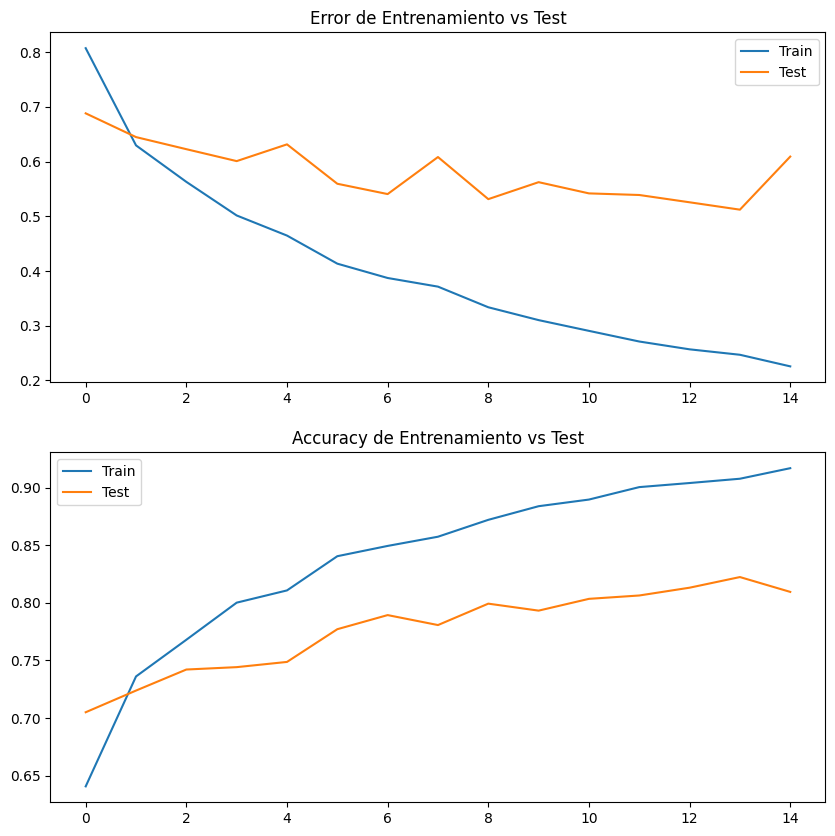

In [ ]:


optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, resnet18_model.parameters()),
    lr=0.0001)

#optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=0.0001)
#loss = torch.nn.CrossEntropyLoss()
loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES,average='macro' )
data = {"train": aug_train_loader, "valid": aug_test_loader, "image_width": ANCHO_IMAGENES, "image_height": ALTO_IMAGENES}
writer = {"train": SummaryWriter(log_dir="transfer_learning_resnet18/train"),
          "valid": SummaryWriter(log_dir="transfer_learning_resnet18/valid")}


history = train(resnet18_model.to('cpu'),
                optimizer,
                loss,
                metric,
                data,
                15,
                writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Test')
axs[0].legend(['Train', 'Test'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Test')
axs[1].legend(['Train', 'Test'])

# arquitectura basica
# Epoch: 15/15 - Train loss 0.584816 - Train Accuracy 0.653090 - Valid Loss 0.632798 - Valid Accuracy 0.603356
# data augmentation
# Epoch: 15/15 - Train loss 0.530651 - Train Accuracy 0.700656 - Valid Loss 0.544694 - Valid Accuracy 0.701688
# TL vgg19 fc
# Epoch: 15/15 - Train loss 0.817499 - Train Accuracy 0.479971 - Valid Loss 0.834366 - Valid Accuracy 0.478292
# TL resnet18 fc
# Epoch: 15/15 - Train loss 0.783415 - Train Accuracy 0.501027 - Valid Loss 0.851920 - Valid Accuracy 0.472704
# TL resnet18 layer 4
#Epoch: 15/15 - Train loss 0.206283 - Train Accuracy 0.909893 - Valid Loss 0.481221 - Valid Accuracy 0.780771

In [ ]:
resnet18_model.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def calcular_matriz_confusion(model, data_loader):
    model.eval()  # Establecer el modelo en modo evaluación
    y_true = []
    y_pred = []

    with torch.no_grad():  # Desactivar el cálculo de gradientes
        for inputs, labels in data_loader:
            inputs = inputs.to('cuda')  # Mover los inputs a la GPU
            labels = labels.to('cuda')  # Mover las etiquetas a la GPU

            outputs = model(inputs)  # Pasar los inputs por el modelo
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())  # Mover las etiquetas a la CPU
            y_pred.extend(predicted.cpu().numpy())  # Mover las predicciones a la CPU

    return y_true, y_pred

In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que calcular_matriz_confusion está definido para obtener y_true y y_pred

# 1. Calcular las etiquetas verdaderas y las predicciones
y_true, y_pred = calcular_matriz_confusion(resnet18_model, aug_test_loader)

# 2. Calcular la matriz de confusión usando sklearn
matriz_confusion = confusion_matrix(y_true, y_pred)

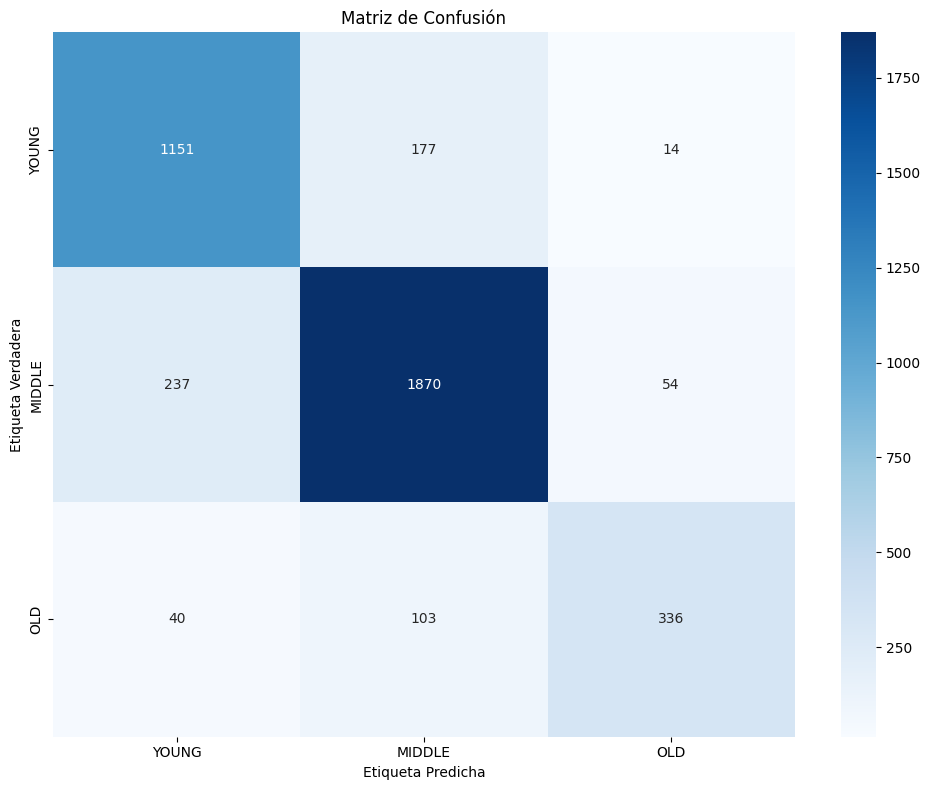

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def graficar_matriz_confusion(matriz, clases, titulo='Matriz de Confusión', cmap='Blues'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz, annot=True, fmt='d', cmap=cmap,
                xticklabels=clases, yticklabels=clases)

    plt.title(titulo)
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.tight_layout()  # Mejora el espaciado
    plt.show()

# Definir las clases (puedes personalizar estos nombres)
clases = ['YOUNG', 'MIDDLE', 'OLD']  # Sustituye por tus clases

# Graficar la matriz de confusión
graficar_matriz_confusion(matriz_confusion, clases)